In [1]:
from scipy.misc import imsave
import numpy as np
import time
from keras.models import load_model
from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
model = load_model('models/mscnn1.h5')

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [6]:
layer_dict

{'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x113c94f60>,
 'batch_normalization_2': <keras.layers.normalization.BatchNormalization at 0x10ea34128>,
 'batch_normalization_3': <keras.layers.normalization.BatchNormalization at 0x113ca03c8>,
 'batch_normalization_4': <keras.layers.normalization.BatchNormalization at 0x113ca0a58>,
 'batch_normalization_5': <keras.layers.normalization.BatchNormalization at 0x113ca0cf8>,
 'batch_normalization_6': <keras.layers.normalization.BatchNormalization at 0x113cb3198>,
 'batch_normalization_7': <keras.layers.normalization.BatchNormalization at 0x113cb3438>,
 'concatenate_1': <keras.layers.merge.Concatenate at 0x113c94ef0>,
 'dropout_1': <keras.layers.core.Dropout at 0x113cb32b0>,
 'dropout_2': <keras.layers.core.Dropout at 0x113cb3550>,
 'fc1': <keras.layers.core.Dense at 0x113cb3048>,
 'fc2': <keras.layers.core.Dense at 0x113cb32e8>,
 'final': <keras.layers.core.Dense at 0x113cb3588>,
 'flatten_1': <keras.layers.core.Fl

In [10]:
img_width = 32
img_height = 32

# the name of the layer we want to visualize
layer_name = 'set2_conv3'
filter_index = 0  

input_img_data = np.random.random((1, img_width, img_height, 3)) * 20 + 128.

input_img_data.shape

(1, 32, 32, 3)

In [11]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
vgglike.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
set1_conv1 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
set1_conv2 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
set1_pool (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
set2_conv1 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
set2_conv2 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
set2_conv3 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
set2_pool (MaxPooling2D)     (None, 8, 8, 64)          0         
__________

In [14]:
# tf placeholder
input_img = vgglike.input
input_img

<tf.Tensor 'set1_conv1_input:0' shape=(?, 32, 32, 3) dtype=float32>

In [15]:
kept_filters = []
for filter_index in range(64):
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Processing filter 0
Current loss value: 0.0
Filter 0 processed in 0s
Processing filter 1
Current loss value: 0.0
Filter 1 processed in 0s
Processing filter 2
Current loss value: 0.0
Filter 2 processed in 0s
Processing filter 3
Current loss value: 0.0
Filter 3 processed in 0s
Processing filter 4
Current loss value: 0.701583
Current loss value: 2.88182
Current loss value: 6.62733
Current loss value: 9.45855
Current loss value: 12.4347
Current loss value: 16.7281
Current loss value: 21.1637
Current loss value: 25.4108
Current loss value: 31.5203
Current loss value: 36.9048
Current loss value: 42.4401
Current loss value: 47.3804
Current loss value: 55.942
Current loss value: 65.6637
Current loss value: 74.107
Current loss value: 83.5105
Current loss value: 93.5599
Current loss value: 103.639
Current loss value: 115.761
Current loss value: 128.049
Filter 4 processed in 0s
Processing filter 5
Current loss value: 0.0
Filter 5 processed in 0s
Processing filter 6
Current loss value: 0.0
Filter 

Current loss value: 0.0
Filter 48 processed in 0s
Processing filter 49
Current loss value: 0.0
Filter 49 processed in 0s
Processing filter 50
Current loss value: 0.0
Filter 50 processed in 0s
Processing filter 51
Current loss value: 0.0
Filter 51 processed in 0s
Processing filter 52
Current loss value: 0.0
Filter 52 processed in 0s
Processing filter 53
Current loss value: 2.86273
Current loss value: 6.35894
Current loss value: 7.39395
Current loss value: 8.43905
Current loss value: 10.0985
Current loss value: 10.943
Current loss value: 13.2337
Current loss value: 15.2927
Current loss value: 17.9535
Current loss value: 18.864
Current loss value: 21.4225
Current loss value: 24.7442
Current loss value: 27.5414
Current loss value: 30.42
Current loss value: 33.4884
Current loss value: 36.5836
Current loss value: 40.3961
Current loss value: 44.1352
Current loss value: 48.0634
Current loss value: 51.7756
Filter 53 processed in 0s
Processing filter 54
Current loss value: 0.105939
Current loss 

IndexError: list index out of range

In [21]:
n = 3

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

/Users/wwymak/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [20]:
from keras.applications import vgg16
layer_name = 'block5_conv1'
model = vgg16.VGG16(weights='imagenet', include_top=False)
model.summary()

58892288/58889256 [==============================] - 13s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [23]:
train_data = np.load('data/X_train_normed.npy')

In [24]:
train_data[0].shape

(32, 32, 3)

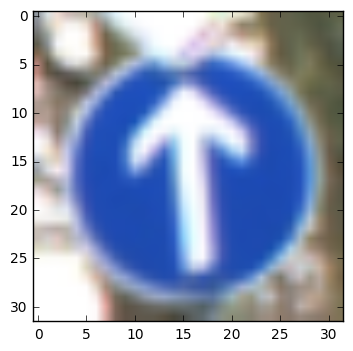

In [29]:
plt.imshow(train_data[20000])

In [32]:
def visualiser(input_img_data):
    input_img = vgglike.input
    kept_filters = []
    layer_name = 'set2_conv3'
    for filter_index in range(16):
        print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])
    
        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]
    
        # normalization trick: we normalize the gradient
        grads = normalize(grads)
    
        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])
    
        # step size for gradient ascent
        step = 1.
#         input_img_data = [input_img_data]
        # we start from a gray image with some random noise
#         if K.image_data_format() == 'channels_first':
#             input_img_data = np.random.random((1, 3, img_width, img_height))
#         else:
#             input_img_data = np.random.random((1, img_width, img_height, 3))
#         input_img_data = (input_img_data - 0.5) * 20 + 128
    
        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
    
            print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break
    
        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    # we will stich the best 64 filters on a 8 x 8 grid.
    n = np.floor(np.sqrt(len(kept_filters)))
    
    print(n)
    
    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    return kept_filters
#     kept_filters = kept_filters[:n * n]
    
    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
#     margin = 5
#     width = n * img_width + (n - 1) * margin
#     height = n * img_height + (n - 1) * margin
#     stitched_filters = np.zeros((width, height, 3))
    
#     # fill the picture with our saved filters
#     for i in range(n):
#         for j in range(n):
#             img, loss = kept_filters[i * n + j]
#             stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
#                              (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
#     plt.imshow(stitched_filters)
    
    # save the result to disk
#     imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

In [36]:
a = [train_data[20000]]

In [38]:
a = np.array(a)

In [40]:
filters = visualiser(a)

Processing filter 0
Current loss value: 0.00699348
Current loss value: 0.130808
Current loss value: 0.884833
Current loss value: 2.70909
Current loss value: 6.00883
Current loss value: 9.66222
Current loss value: 13.2647
Current loss value: 17.5839
Current loss value: 22.5328
Current loss value: 26.8574
Current loss value: 32.1772
Current loss value: 36.2345
Current loss value: 41.5707
Current loss value: 46.6517
Current loss value: 52.3672
Current loss value: 58.1754
Current loss value: 63.8405
Current loss value: 70.3164
Current loss value: 76.1754
Current loss value: 82.71
Processing filter 1
Current loss value: 0.0
Processing filter 2
Current loss value: 0.10401
Current loss value: 1.66429
Current loss value: 7.99962
Current loss value: 17.8634
Current loss value: 28.9952
Current loss value: 40.9591
Current loss value: 52.523
Current loss value: 66.093
Current loss value: 79.9185
Current loss value: 94.1567
Current loss value: 107.385
Current loss value: 122.341
Current loss value:

TypeError: slice indices must be integers or None or have an __index__ method